In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import datetime as dt

In [3]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import ArmaProcess

In [82]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [17]:
#the data was loaded from here
#https://www.kaggle.com/rockbottom73/crude-oil-prices/data#

In [4]:
data = pd.read_excel("Crude Oil Prices Daily.xlsx")

In [5]:
data.head()

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


### Visualizing oil prices

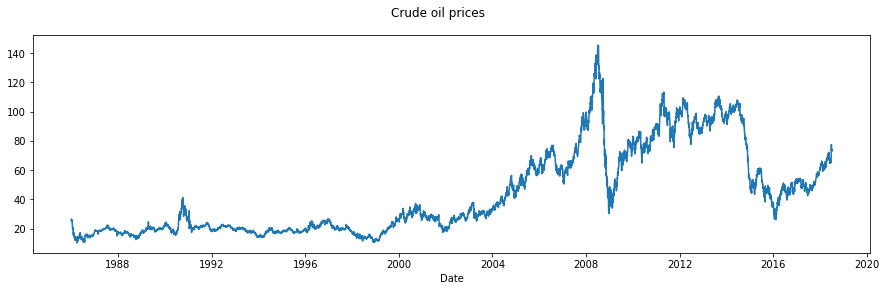

In [6]:
plt.figure(figsize = (15,4))
plt.plot(data.Date,data['Closing Value'])
plt.xlabel('Date')
plt.suptitle('Crude oil prices')
plt.show()

Let us look at the shorter time period, say, from 2007.

In [7]:
short_date = data.Date > pd.to_datetime("2007.01.01")

In [8]:
short_data = data[short_date]

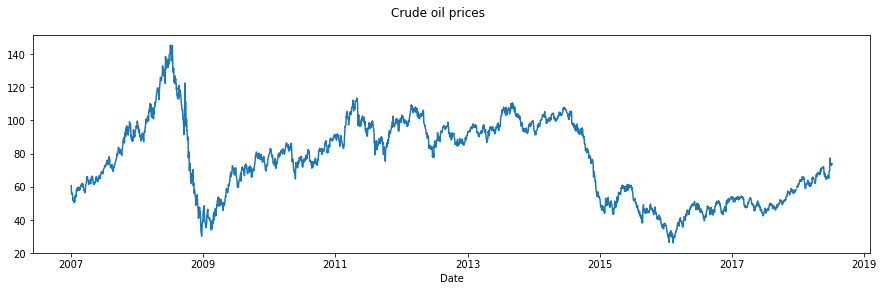

In [9]:
plt.figure(figsize = (15,4))
plt.plot(short_data.Date,short_data['Closing Value'])
plt.xlabel('Date')
plt.suptitle('Crude oil prices')
plt.show()

#### Working with time series analysis requires the data to be stationary. Hence, we transform oil prices into log-returns.

Now we will work with the time series analysis. For this, however, it is better to look at returns instead of prices. 

In [62]:
df = short_data
df = df.set_index(short_data.Date)
df = df.drop(columns = ['Date'])

In [63]:
df['LogRet'] = np.log(df['Closing Value']) - np.log(df['Closing Value'].shift(1))

In [65]:
df = df.dropna(how = 'any')

Let us now look at the returns of oil prices. 

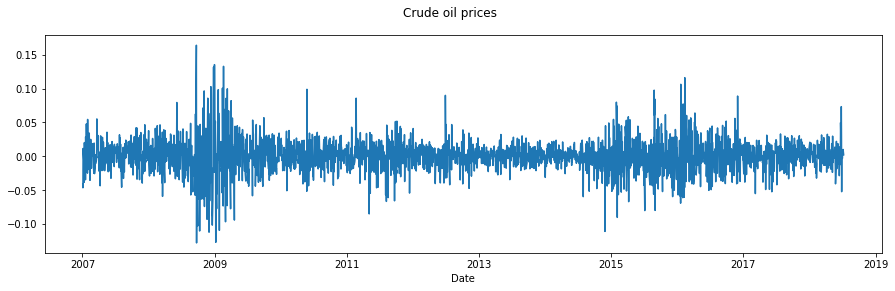

In [66]:
plt.figure(figsize = (15,4))
plt.plot(df.index,df.LogRet)
plt.xlabel('Date')
plt.suptitle('Crude oil prices')
plt.show()

### Does this time series of returns exhibit autocorrelation? 

Let us look at the ACF and PACF plots to see whether an ARMA process would fit these time series. 

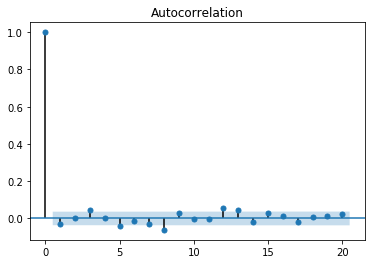

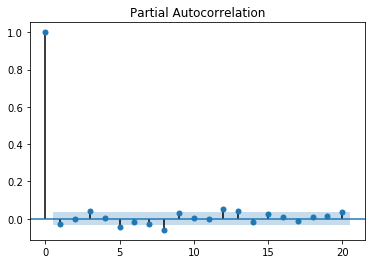

In [67]:
#plot acf plot, with lags = 20 and confidence 5%
plot_acf(df.LogRet, lags = 20, alpha = 0.05)
plot_pacf(df.LogRet, lags = 20, alpha = 0.05)
plt.show()

We don't find any significant autocorrelation. But the reason for that might be that the time series are too long to identify a consistent autocorreltion on it.  Let us shrink this dataframe to one year window (e.g. 2007) and see what happens there.

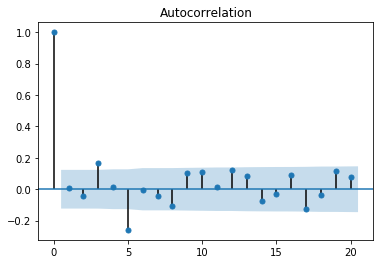

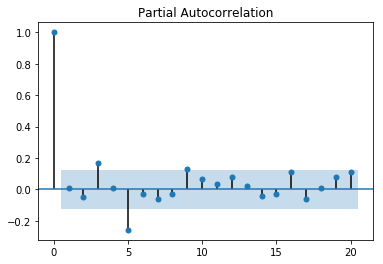

In [74]:
df2008 = df[(df.index<pd.to_datetime('2009.01.01'))&(df.index>pd.to_datetime('2008.01.01'))]
plot_acf(df2008.LogRet, lags = 20, alpha = 0.05)
plot_pacf(df2008.LogRet, lags = 20, alpha = 0.05)
plt.show()

We can see that for the one year window, the time series do exhibit some autocorrelation. 

Before we fit ARMA model, we verify that the resulting time series are stationary

In [75]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(df2008.LogRet)
results

(-7.907062358749889,
 4.040114407705629e-12,
 4,
 248,
 {'1%': -3.4569962781990573,
  '10%': -2.573018897632674,
  '5%': -2.8732659015936024},
 -857.9395362324312)

The 0-value is the t-statistics, the first value is the p-value. The p-value is small (less than 0.01), hence, the unit root null-hypothesis is rejected at significance level 1%. 

### Is seasonality an issue?

Commodities returns very often exhibit seasonality. While ACF does not produce a clear seasonability pattern, we can nevertheless decompose the returns using statsmodels.tsa.seasonal and see the result.

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [78]:
decomp_results = seasonal_decompose(df2008.LogRet, freq = 13)

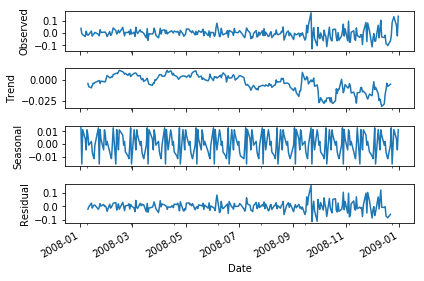

In [79]:
decomp_results.plot()
plt.show()

While the plot above shows some seasonality in time series, the returns of "trend" and "seasonal" are by the order of magnitude smaller than that of "residual". Residuals actually almost exactly mimic the observed time series. We will start with the 

### ARMA fit

We will now fit an ARMA model to our 1 year time series. 

In [22]:
from statsmodels.tsa.arima_model import ARMA

To identify the order of an ARMA model, we will once again look at the ACF and PACF plots. Let us do a lag up until 5.

Based on ACF and PACF plots, let us include lag up to 5. We will chose the best model fit based on the Akaike information criteria.

In [92]:
#set the list of (p,q)'s we consider
set_ind = [(i,j) for i in range(1,6) for j in range(1,6)]

#dictionary with (p,q) as keys and AIC as values
dict_aic = {}

for (i,j) in set_ind:
    try:
        mod = ARMA(df2008.LogRet, order = (i,j))
        result = mod.fit()
        #print(result.summary())
        dict_aic[(i,j)] = result.aic
    except:
        print("Error in fitting the ARMA model")

Error in fitting the ARMA model


In [93]:
print(dict_aic)

{(1, 1): -912.383930209902, (1, 2): -911.2705889163735, (1, 3): -916.1528718829152, (1, 4): -920.0884569837733, (1, 5): -926.7403048450133, (2, 1): -911.757047697969, (2, 2): -927.8538777268368, (2, 3): -919.7537403642405, (2, 4): -925.37594645524, (2, 5): -924.9311479000637, (3, 1): -915.8736092987585, (3, 2): -920.7328949591661, (3, 3): -900.1048503135837, (3, 4): -923.3763944979275, (3, 5): -923.5513825434577, (4, 1): -918.3445877668639, (4, 2): -936.2394405054351, (4, 3): -901.1408245390512, (4, 4): -920.6096678383053, (4, 5): -945.2685379312588, (5, 1): -930.4439505842404, (5, 2): -928.7611624268509, (5, 3): -932.8174702835865, (5, 4): nan}


We wish to select, from among the candidate models, the model that minimizes the information loss

In [94]:
min(dict_aic.values())

-945.2685379312588

In [101]:
winner_arma = (4,5)

In [108]:
mod = ARMA(df2008.LogRet, order = winner_arma)
result = mod.fit()

In [107]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 LogRet   No. Observations:                  253
Model:                     ARMA(4, 5)   Log Likelihood                 483.634
Method:                       css-mle   S.D. of innovations              0.035
Date:                Sat, 21 Dec 2019   AIC                           -945.269
Time:                        17:20:05   BIC                           -906.401
Sample:                             0   HQIC                          -929.631
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0034      0.002     -1.534      0.126      -0.008       0.001
ar.L1.LogRet     0.7909      0.033     24.118      0.000       0.727       0.855
ar.L2.LogRet    -0.7365      0.034    -21.595      0.000      -0.803      -0.670
ar.L3.LogRet     0.7889      0.029     27.058      0.000       0.732       0.846
ar.L4.LogRet    -0.9664      0.025    -37.954      0.000      -1.016      -0.917
ma.L1.LogRet    -0.8613      0.077    -11.180      0.000      -1.012      -0.710
ma.L2.LogRet     0.8282      0.070     11.849      0.000       0.691       0.965
ma.L3.LogRet    -0.7386      0.079     -9.309      0.000      -0.894      -0.583
ma.L4.LogRet     0.9751      0.070     13.887      0.000       0.837       1.113
ma.L5.LogRet    -0.1018      0.074     -1.367      0.173      -0.248       0.044
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3957           -0.9250j            1.0061           -0.3143
AR.2           -0.3957           +0.9250j            1.0061            0.3143
AR.3            0.8039           -0.6132j            1.0111           -0.1037
AR.4            0.8039           +0.6132j            1.0111            0.1037
MA.1           -0.4130           -0.9542j            1.0398           -0.3150
MA.2           -0.4130           +0.9542j            1.0398            0.3150
MA.3            0.7762           -0.6511j            1.0132           -0.1111
MA.4            0.7762           +0.6511j            1.0132            0.1111
MA.5            8.8505           -0.0000j            8.8505           -0.0000
-----------------------------------------------------------------------------
"""

### Predicting using SARIMAX

We will now use Statsmodels Sarimax class to make predictions

In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [111]:
model = SARIMAX(df2008.LogRet, order = (winner_arma[0], 0, winner_arma[1]))

In [126]:
#make predictions for last 25 values
results = model.fit()
forecast = results.get_prediction(start = -25, dynamic = True)

In [127]:
#forecast mean
mean_forecast = forecast.predicted_mean

In [128]:
#you can have also the confidence intervals
conf_inter = forecast.conf_int()

In [129]:
#wow, this confidence interval is quite wide
conf_inter.head()

,lower LogRet,upper LogRet
Date,,
2008-11-25,-0.081740,0.060979
2008-11-26,-0.063483,0.079252
2008-11-28,-0.032922,0.109872
2008-12-01,-0.062429,0.082671
2008-12-02,-0.081073,0.064150


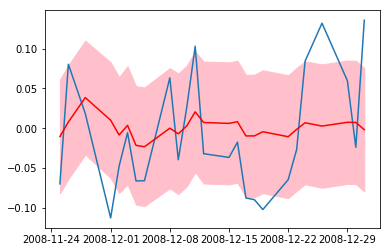

In [132]:
plt.figure()
plt.plot(mean_forecast.index, df2008.LogRet[mean_forecast.index])
plt.plot(mean_forecast.index, mean_forecast.values, color = 'red', label = 'forecast')
plt.fill_between(mean_forecast.index, conf_inter['lower LogRet'], 
                  conf_inter['upper LogRet'], color = 'pink')
plt.show()